# **Project: MapGAN**
## Authors: Neill Shikada and Melanie Sharif
## Professor: Robin Burke
## Course: INFO5604

If you want to run this code locally using Anaconda, follow the instructions [here](https://research.google.com/colaboratory/local-runtimes.html):
1. Open Anaconda command prompt

2. Ensure that Jupyter has the proper extensions enabled
  `jupyter-serverextension enable jupyter_http_over_ws`

3. Run Jupyter Notebook and allow access to Google Colab with this code
  `jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com'`
  
4. Click the dropdown in the top left of Google Colab Notebook, select `Connect to a local runtime`

5. Copy the `http://localhost:8888/?token=###`  link from the Anaconda command prompt

6. Paste into the Google Colab url space

7. It should connect! Then keep the Jupyter Notebook open the whole time you code as this is where your code is running locally

# Import Dependencies

1. Install any package that needs to be installed

In [1]:
!pip install earthengine-api --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 3.1 MB/s 
     |████████████████████████████████| 46 kB 2.0 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 3.7 MB 6.0 MB/s 
     |████████████████████████████████| 198 kB 49.3 MB/s 
     |████████████████████████████████| 99 kB 5.2 MB/s 
     |████████████████████████████████| 98 kB 4.6 MB/s 
     |████████████████████████████████| 1.3 MB 6.3 MB/s 
     |████████████████████████████████| 1.2 MB 22.5 MB/s 
     |████████████████████████████████| 130 kB 18.8 MB/s 
     |████████████████████████████████| 3.5 MB 11.6 MB/s 
     |████████████████████████████████| 128 kB 20.6 MB/s 
     |████████████████████████████████| 1.6 MB 45.1 MB/s 
     |████████████████████████████████| 79 kB 1.0 MB/s 
  Created wheel for ee-extra: filename=ee_extra-0.0.14-py3-none-any.whl size=209116 sha256=4f388e79bb3

2. Install packages to build neural network

In [3]:
import scipy as sp    # import scipy for 
import pandas as pd   # import pandas for data formatting
import numpy as np    # import numpy for data formatting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sb

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD

In [7]:
from PIL import Image
from tqdm import tqdm
import os 
import time

3. Install Google libraries

In [8]:
# geemap is Google Earth Engine's bespoke visualization library
import geemap

In [9]:
# Enable access to Google Earth Engine. If you are running this locally, you have to right click and open the link in a new tab (otherwise it'll come up with an error)
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=RjZDx-M2sqa6s4YmgBdhDIRd3SylrM-PyB4gtxdFa_Q&tc=ULmsrpJYGHgf9dvjF0FEfTWOmLy8suw4LK3D4gcK1Fg&cc=X0JJGjt_MMQJ1E-CrvdpeXOk4-WB9Sh1SSBH2RJPfRU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvucmK1PN_pnKTwvjNHbUvEX8uDqS7ifcRPIg4MhdhsAjBVysAnOYG0

Successfully saved authorization token.


In [10]:
# Import Google drive so we can export our data and models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Variables

## Specify Cloud Storage Bucket
Google Colab uses Google Storage Buckets to run any code, so you have to have one and specify it!

In [20]:
OUTPUT_BUCKET = '/content/drive/MyDrive/mapGAN/output'

Define database variables. Here, we're using a database of [global settlement patterns](https://developers.google.com/earth-engine/datasets/catalog/DLR_WSF_WSF2015_v1) and [Landsat 9 imagery](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1?hl=en)

In [21]:
L8SR = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

Define the file paths for data

In [22]:
TRAIN_FILE_PREFIX = 'Training_demo'
TEST_FILE_PREFIX = 'Testing_demo'
file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension
TEST_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TEST_FILE_PREFIX + file_extension


In [23]:
# Use these bands for prediction.
# The bands are different for each dataset in Earth Engine, but we are looking for the raw RGB values of the images
BANDS = ['B4', 'B3', 'B2']

# These names are used to specify properties in the export of
# training/testing data and to define the mapping between names and data
# when reading into TensorFlow datasets.
FEATURE_NAMES = list(BANDS)

# File names for the training and testing datasets.  These TFRecord files
# will be exported from Earth Engine into the Cloud Storage bucket.
TRAIN_FILE_PREFIX = 'Training'
FILE_EXT = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension

# File name for the prediction (image) dataset.  The trained model will read
# this dataset and make predictions in each pixel.
IMAGE_FILE_PREFIX = 'Image_pixel'

# The output path for the classified image (i.e. predictions) TFRecord file.
OUTPUT_IMAGE_FILE = 'gs://' + OUTPUT_BUCKET + '/Classified_pixel.TFRecord'

## Define the Coordinate Feature Collection
A feature collection is a type of dataset standard in Google Earth Engine. In this one, we're creating a library of coordinates corresponding to the megacities of the world. For our purposes, a megacity is any city with a population of more than 10 million people. This list was made according to [this Wikipedia article](https://en.wikipedia.org/wiki/Megacity)

In [24]:
# https://mbonnema.github.io/GoogleEarthEngine/05-time-series/
# https://developers.google.com/earth-engine/apidocs/ee-featurecollection
# https://developers.google.com/earth-engine/apidocs/ee-geometry-point-coordinates

megacitiesDict = [
  ee.Feature(ee.Geometry.Point(77.3530, 12.5844), {'city': 'Bangalore'}),
  ee.Feature(ee.Geometry.Point(100.2939, 13.4509), {'city': 'Bangkok'}),
  ee.Feature(ee.Geometry.Point(116.2351, 39.5424 ), {'city': 'Beijing'}),
  ee.Feature(ee.Geometry.Point(-74.420, 4.4240), {'city': 'Bogota'}),
  ee.Feature(ee.Geometry.Point(-58.2254, -34.3612), {'city': 'Buenos Aires'}),
  ee.Feature(ee.Geometry.Point(31.14, 30.02), {'city': 'Cairo'}),
  ee.Feature(ee.Geometry.Point(104.0348, 30.3936), {'city': 'Chengdu'}),
  ee.Feature(ee.Geometry.Point(80.16145, 13.04577), {'city': 'Chennai'}),
  ee.Feature(ee.Geometry.Point(106.3301, 29.3349), {'city': 'Chongqing'}),
  ee.Feature(ee.Geometry.Point(77.1348, 28.3636), {'city': 'Delhi'}),
  ee.Feature(ee.Geometry.Point(90.2320, 23.4550), {'city': 'Dhaka'}),
  ee.Feature(ee.Geometry.Point(113.1536, 23.0748), {'city': 'Guangzhou'}),
  ee.Feature(ee.Geometry.Point(120.0911, 30.1601), {'city': 'Huangzhou'}),
  ee.Feature(ee.Geometry.Point(106.4207, 10.4632), {'city': 'Ho Chi Minh City'}),
  ee.Feature(ee.Geometry.Point(78.29121, 17.23060), {'city': 'Hyderabad'}),
  ee.Feature(ee.Geometry.Point(28.5718, 41.0049), {'city': 'Istanbul'}),
  ee.Feature(ee.Geometry.Point(106.4939, -6.1030), {'city': 'Jakarta'}),
  ee.Feature(ee.Geometry.Point(28.244, -26.1216), {'city': 'Johannesburg'}),
  ee.Feature(ee.Geometry.Point(67.036, 24.5136), {'city': 'Karachi'}),
  ee.Feature(ee.Geometry.Point(15.1920, -4.1930), {'city': 'Kinshasa'}),
  ee.Feature(ee.Geometry.Point(88.2212, 22.3403), {'city': 'Kolkata'}),
  ee.Feature(ee.Geometry.Point(3.384082, 6.455027), {'city': 'Lagos'}),
  ee.Feature(ee.Geometry.Point(74.2037, 31.3259), {'city': 'Lahore'}),
  ee.Feature(ee.Geometry.Point(-77.0215, -12.0336), {'city': 'Lima'}),
  ee.Feature(ee.Geometry.Point(-0.739, 51.3026), {'city': 'London'}),
  ee.Feature(ee.Geometry.Point(-118.15, 34.03), {'city': 'Los Angeles'}),
  ee.Feature(ee.Geometry.Point(121, 14.58), {'city': 'Metro Manila'}),
  ee.Feature(ee.Geometry.Point(-99.8, 19.26), {'city': 'Mexico City'}),
  ee.Feature(ee.Geometry.Point(37.372, 55.4521), {'city': 'Moscow'}),
  ee.Feature(ee.Geometry.Point(72.5239, 19.0434), {'city': 'Mumbai'}),
  ee.Feature(ee.Geometry.Point(136.54, 35.11), {'city': 'Nagoya'}),
  ee.Feature(ee.Geometry.Point(-74.0022, 40.4246), {'city': 'New York City'}),
  ee.Feature(ee.Geometry.Point(135.308, 34.4138), {'city': 'Osaka'}),
  ee.Feature(ee.Geometry.Point(2.2108, 48.5124), {'city': 'Paris'}),
  ee.Feature(ee.Geometry.Point(-43.1221, -22.5441), {'city': 'Rio de Janeiro'}),
  ee.Feature(ee.Geometry.Point(-46.38, -23.33), {'city': 'São Paulo'}),
  ee.Feature(ee.Geometry.Point(126.5924, 37.3336), {'city': 'Seoul'}),
  ee.Feature(ee.Geometry.Point(121.2829, 31.1343), {'city': 'Shanghai'}),
  ee.Feature(ee.Geometry.Point(114.0335, 22.3229), {'city': 'Shenzhen'}),
  ee.Feature(ee.Geometry.Point(51.2320, 35.4121), {'city': 'Tehran'}),
  ee.Feature(ee.Geometry.Point(117.1219, 39.0801), {'city': 'Tianjin'}),
  ee.Feature(ee.Geometry.Point(139.4132, 35.4123), {'city': 'Tokyo'}),
  ee.Feature(ee.Geometry.Point(114.1817, 30.3536), {'city': 'Wuhan'}),
  ee.Feature(ee.Geometry.Point(118.0520, 24.2847), {'city': 'Xiamen'}),
  ee.Feature(ee.Geometry.Point(108.5714, 34.1554), {'city': 'Xi\'an'})
]

megacitiesFC = ee.FeatureCollection(megacitiesDict)

In [25]:
megacitiesFC

## Visualize the dataset
Use geemap to show what the dataset looks like on a map of Earth

In [30]:
def bounding_box_func(feature):
    intermediate_buffer = feature.buffer(40000);  # buffer radius, half your box width in m
    intermediate_box = intermediate_buffer.bounds(); # Draw a bounding box around the circle
    return(intermediate_box); # Return the bounding box

In [31]:
clipFC = megacitiesFC.map(bounding_box_func)

In [89]:
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

Map = geemap.Map(zoom = 10)

# Cloud masking function to get rid of as many clouds as we can
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000)

def clipImage(image):
  image = image.clip(clipFC)
  image = image.select('B4', 'B3', 'B2')
  return image

imageCollection = L8SR.map(maskL8sr)
imageCollection = imageCollection.map(clipImage).filterBounds(megacitiesFC).sort('CLOUD COVER')


# The image input data is a cloud-masked median composite
# image = L8SR.filterDate('2015-01-01', '2017-12-31').filterBounds(megacitiesFC).map(maskL8sr).median()
# image = image.select('B4', 'B3', 'B2')

# image = image.clip(ee.Geometry.Polygon([geo1, geo2, geo3, geo4]))
# image = image.clipToCollection(clipFC)

# This creates an imageCollection of the data to work with instead of an image
# collection = L8SR.filterDate('2015-01-01', '2017-12-31').filterBounds(megacitiesFC).map(maskL8sr)

# TODO write a function to create a bounding box around each city
# TODO write a function that takes "image" and seperates it into an imageCollection of each city

# sets image variables
rgbVis = {
  'bands': BANDS,
  'min': 0,
  'max': 0.3
};

Map.setCenter(139.6503, 35.6762)
# adds image layers to map
# Map.addLayer(collection, rgbVis, 'Cities: Collection')
Map.addLayer(imageCollection, rgbVis, 'Cities: Image')

Map

Map(center=[35.6762, 139.6503], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [83]:
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

Map = geemap.Map(zoom = 10)

# Cloud masking function to get rid of as many clouds as we can
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000)
  
# The image input data is a cloud-masked median composite
image = L8SR.filterDate('2015-01-01', '2017-12-31').filterBounds(megacitiesFC).map(maskL8sr).median()
image = image.select('B4', 'B3', 'B2')

image = image.clipToCollection(clipFC)

# TODO write a function to create a bounding box around each city
# TODO write a function that takes "image" and seperates it into an imageCollection of each city

# sets image variables
rgbVis = {
  'bands': BANDS,
  'min': 0,
  'max': 0.3
};

Map.setCenter(139.6503, 35.6762)
# adds image layers to map
# Map.addLayer(collection, rgbVis, 'Cities: Collection')
Map.addLayer(image, rgbVis, 'Cities: Image')

Map

Map(center=[35.6762, 139.6503], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [54]:
ee.Algorithms.Describe(imageCollection)

Name,Units,Scale,Wavelength,Description
B1,,0.0001,0.435-0.451 μm,Band 1 (ultra blue) surface reflectance
B2,,0.0001,0.452-0.512 μm,Band 2 (blue) surface reflectance
B3,,0.0001,0.533-0.590 μm,Band 3 (green) surface reflectance
B4,,0.0001,0.636-0.673 μm,Band 4 (red) surface reflectance
B5,,0.0001,0.851-0.879 μm,Band 5 (near infrared) surface reflectance
B6,,0.0001,1.566-1.651 μm,Band 6 (shortwave infrared 1) surface reflectance
B7,,0.0001,2.107-2.294 μm,Band 7 (shortwave infrared 2) surface reflectance
B10,Kelvin,0.1,10.60-11.19 μm,"Band 10 brightness temperature. This band, while originally collected with a resolution of 100m / pixel, has been resampled using cubic convolution to 30m."
B11,Kelvin,0.1,11.50-12.51 μm,"Band 11 brightness temperature. This band, while originally collected with a resolution of 100m / pixel, has been resampled using cubic convolution to 30m."
sr_aerosol,,,,Aerosol attributes


In [67]:
type(imageCollection)

ee.imagecollection.ImageCollection

In [68]:
imageCollection.size()

In [90]:
geemap.ee_export_image_to_drive(
    imageCollection.first(), description='landsat', folder='export', scale=30
)

## Export the Data in TFRecord format
Google Earth Engine can export data in TFRecord format. This is what we need to do to allow us to use the data in a Tensorflow model.

1. We want to verify that we can see the output folder on Google Drive

In [69]:
# Make sure you can see the output bucket.  You must have write access.
print('Found Cloud Storage bucket.' if tf.io.gfile.exists(OUTPUT_BUCKET) 
    else 'Can not find output Cloud Storage bucket.')

Found Cloud Storage bucket.


2. Setup the export function with all options. We are exporting in the TFRecord file format

In [71]:
# Export function if you are exporting an ImageCollection
export = ee.batch.Export.table.toDrive(
    collection = imageCollection,
    description = 'collection_export_2',
    folder = OUTPUT_BUCKET,
    fileNamePrefix = IMAGE_FILE_PREFIX,
    fileFormat = 'TFRecord',
)

In [ ]:
# Specify patch and file dimensions.
image_export_options = {
  'patchDimensions': [128, 128],
  'maxFileSize': 104857600,
  'compressed': True
}

# Export function if you are exporting an Image
export = ee.batch.Export.image.toDrive(
    image = image,
    description = 'image_export',
    folder = OUTPUT_BUCKET,
    fileNamePrefix = IMAGE_FILE_PREFIX,
    fileFormat = 'TFRecord',
    formatOptions=image_export_options,
)

3. Begin the export function. This runs remotely on the Google Earth Engine servers. This function simply sends the data off to their system and it'll run in tandem with this program.

In [72]:
export.start()

4. Keep us updated on the status of the batch job we just sent.

In [73]:
import time

while export.active():
  print('Polling for task (id: {}).'.format(export.id))
  time.sleep(30)
print('Done with image export.')

Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Polling for task (id: GV5EEYKOZ3P5KFUHKAHS2DA3).
Done with image export.


5. Check if the job was a success. If not, reference Stack Overflow and Youtube a lot as I did. Error messages don't show up in Google Colab, you'll have to go to the Earth Engine coding environment to see the error code.

In [74]:
print(ee.batch.Task.list())

[<Task GV5EEYKOZ3P5KFUHKAHS2DA3 EXPORT_FEATURES: collection_export_2 (COMPLETED)>, <Task 745PTKTJYPYHEE5NX72A47ER EXPORT_FEATURES: collection_export (COMPLETED)>, <Task QE23R2MJCW2C2DYTU3YS7JZY EXPORT_IMAGE: image_export (FAILED)>, <Task TWPPG67BMZEESG73LTO3Y5QS EXPORT_IMAGE: image_export (FAILED)>, <Task SCLT3SARZFIXVERTCLPOYLYW EXPORT_IMAGE: image_export (FAILED)>, <Task BMAPZWQ3RAV36PVXF27LLFLY EXPORT_IMAGE: image_export (FAILED)>, <Task Y47DQBNSZTNX7MDIGCNDW2UL EXPORT_FEATURES: collection_export (COMPLETED)>, <Task VWGXH3CX5O32SMSV4C363KI3 EXPORT_FEATURES: Testing Export (FAILED)>, <Task 6DH3I2DUAS727DQTEEDICI5Y EXPORT_FEATURES: Training Export (FAILED)>, <Task AGOIDVVQ33FCPP3GLQEKXZH7 EXPORT_FEATURES: Testing Export (FAILED)>, <Task 2MBXAEBODIOZM7RBOKE22PLB EXPORT_FEATURES: Training Export (FAILED)>, <Task A6ZE2VKNKV5G6AXJW5SVXKJF EXPORT_FEATURES: collection_export (COMPLETED)>, <Task M6JH7SCOC5AAMQTZITGBWA6F EXPORT_FEATURES: collection_export3 (COMPLETED)>, <Task X56LYGU3A7UXYUU7

## Import the TFRecordDataset and Convert
We want to load the data we just exported back into the system and get it shaped correctly to work with the CNN we will construct.

In [75]:
# Create a dataset from the TFRecord file in Cloud Storage.
raw_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/mapGAN/output/Image_pixel.tfrecord.gz', compression_type='GZIP')
# Print the first record to check.
print(iter(raw_dataset).next())

tf.Tensor(b'\n*\n(\n\x0csystem:index\x12\x18\n\x16\n\x14LC08_007068_20150113', shape=(), dtype=string)


In [76]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with names as keys, features as values.
features_dict = dict(zip(FEATURE_NAMES, columns))

print(features_dict)

{'B4': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'B2': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


In [ ]:
# Keras requires inputs as a tuple.  Note that the inputs must be in the
# right shape.  Also note that to use the categorical_crossentropy loss,
# the label needs to be turned into a one-hot vector.
def to_tuple(inputs, label):
  return (tf.transpose(list(inputs.values())),
          tf.one_hot(indices=label, depth=3))

# Map the to_tuple function, shuffle and batch.
input_dataset = parsed_dataset.map(to_tuple).batch(8)

TypeError: ignored

In [ ]:
# Dictionary with names as keys, features as values.
features_dict = dict(zip(FEATURE_NAMES, columns))

print(features_dict)

In [ ]:
raw_example = next(iter(raw_dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['B4']

In [ ]:
type(parsed)

tensorflow.core.example.example_pb2.Example

In [ ]:
# Create a description of the features.
feature_description = {
    'B4': tf.io.FixedLenFeature([], tf.float32, default_value=0),
    'B3': tf.io.FixedLenFeature([], tf.float32, default_value=0),
    'B2': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [ ]:
train_dataset_p = train_dataset.map(_parse_function)

In [ ]:
train_dataset_p

<MapDataset element_spec={'B2': TensorSpec(shape=(), dtype=tf.float32, name=None), 'B3': TensorSpec(shape=(), dtype=tf.float32, name=None), 'B4': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [ ]:
for parsed_record in train_dataset_p.take(10):
  print(repr(parsed_record))

{'B2': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B3': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B4': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'B2': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B3': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B4': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'B2': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B3': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B4': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'B2': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B3': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B4': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'B2': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B3': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B4': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'B2': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B3': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'B4': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'B2

In [ ]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with names as keys, features as values.
features_dict = dict(zip(FEATURE_NAMES, columns))

print(features_dict)

{'B4': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'B2': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


In [ ]:
parsed_dataset

<ParallelMapDataset element_spec=({}, TensorSpec(shape=(1,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [ ]:
# Keras requires inputs as a tuple.  Note that the inputs must be in the
# right shape.  Also note that to use the categorical_crossentropy loss,
# the label needs to be turned into a one-hot vector.
def to_tuple(inputs, label):
  return (tf.transpose(list(inputs.values())),
          tf.one_hot(indices=label, depth=3))

# Map the to_tuple function, shuffle and batch.
input_dataset = parsed_dataset.map(to_tuple).batch(8)

TypeError: ignored

# Setup the Neural Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDER = 'fcnn-demo'
TRAINING_BASE = 'training_patches'

GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

RESPONSE = 'impervious'

# Preview image
PREVIEW_ROWS = 2
PREVIEW_COLS = 2
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATASET = l8sr.filterDate('2015-01-01', '2017-12-31').filterBounds(listOfFeaturesFc).map(maskL8sr)
BUCKET = "/content/drive/MyDrive/mapGAN/data"
EPOCHS = 100
BATCH_SIZE = 16
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: ignored

In [ ]:
type(DATASET)

ee.imagecollection.ImageCollection

In [ ]:
# Convert the feature collections to lists for iteration.
TRAINING_DATA = parsed_dataset

training_binary_path = os.path.join(OUTPUT_BUCKET,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

start = time.time()
print("Loading training images...")

training_data = []

# TODO This for loop keeps giving the error "user memory exceeded" even with Google Compute Units
for filename in range(TRAINING_DATA.size().getInfo()):
    path = os.path.join(BUCKET,filename)
    image = Image.open(path).resize((GENERATE_SQUARE,
          GENERATE_SQUARE),Image.ANTIALIAS)
    training_data.append(np.asarray(image))
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
          GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.


print("Saving training image binary...")
np.save(training_binary_path,training_data)
elapsed = time.time()-start

Loading training images...


AttributeError: ignored

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(BUCKET,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
#building the generator
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [ ]:
# 
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

tf.Tensor([[0.5007379]], shape=(1, 1), dtype=float32)


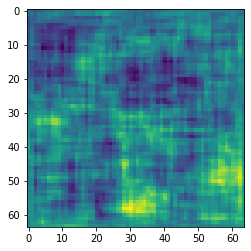

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
#from https://www.tensorflow.org/tutorials/generative/dcgan
#using pre-compiling
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

#training 
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.9690646529197693,disc loss=1.5506353378295898, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 125ms/step
Epoch 2, gen loss=1.2313545942306519,disc loss=1.3242579698562622, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 3, gen loss=0.9897303581237793,disc loss=1.3891716003417969, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=1.120313286781311,disc loss=1.1489533185958862, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 5, gen loss=1.3530868291854858,disc loss=1.042638897895813, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=1.598588466644287,disc loss=0.9105803370475769, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=1.4682759046554565,disc loss=0.8695600032806396, {hms_string(epoch_elapsed)}
1/1 [====================

In [ ]:
# Save the model
generator.save('generator.h5')
discriminator.save('discriminator.h5')